In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("./dataset/haberman.data")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                306 non-null    int64
 1   Year of Operation  306 non-null    int64
 2   Nodes Detected     306 non-null    int64
 3   Survival           306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


In [13]:
df.shape

(306, 4)

In [14]:
df.describe()

,Age,Year of Operation,Nodes Detected,Survival
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


## Preprocessing

In [15]:
df.loc[(df.Survival == 2),'Survival'] = 0 
df['Survival'] = df['Survival'].astype(bool)
df.head()

,Age,Year of Operation,Nodes Detected,Survival
0,30,64,1,True
1,30,62,3,True
2,30,65,0,True
3,31,59,2,True
4,31,65,4,True


In [16]:
X = df.loc[:, df.columns != 'Survival'] 
Y = df['Survival']

In [17]:
X = (X - X.mean())/X.std()
X.head()

,Age,Year of Operation,Nodes Detected
0,-2.078735,0.353006,-0.420903
1,-2.078735,-0.262492,-0.142725
2,-2.078735,0.660755,-0.559991
3,-1.986172,-1.185738,-0.281814
4,-1.986172,0.660755,-0.003636


### Using Gridsearch to choose optimal value for hyper parameter

Selected hyperparameters:  SVC(C=0.75, kernel='sigmoid')
              precision    recall  f1-score   support

       False       0.47      0.21      0.29        81
        True       0.76      0.92      0.83       225

    accuracy                           0.73       306
   macro avg       0.62      0.56      0.56       306
weighted avg       0.69      0.73      0.69       306



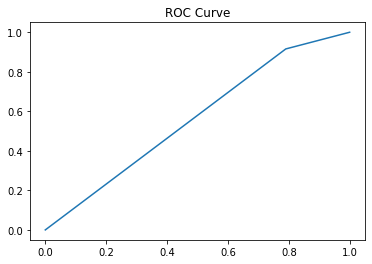

ROC AUC   :  0.5627160493827161
Confusion Matrix: 
 [[ 17  64]
 [ 19 206]]


In [18]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

params_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 0.75, 1, 1.25, 1.5, 10, 100],
    'kernel':['linear','rbf', 'poly', 'sigmoid'] 
}

clf = GridSearchCV(SVC(), params_grid)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X)
print("Selected hyperparameters: ", clf.best_estimator_ )
print(classification_report(Y, y_pred))
fpr, tpr, thresholds = roc_curve(Y, y_pred)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.show()
print('ROC AUC   : ', roc_auc_score(Y, y_pred))
print('Confusion Matrix: \n', confusion_matrix(Y, y_pred))

### Constructing 2D Scatter plot with hyperplane

#### Utility function to compute PCA

In [19]:

def compute_pca(df, k):
    df = df.copy()    
    cov_matrix_list = []
    for y in df['Survival'].unique():
        df_class = df.loc[df['Survival'] == y]
        df_class = df_class.loc[:, df_class.columns != 'Survival']     
        df_class = (df_class - df_class.mean())/df_class.std()
        df_class = df_class - df_class.mean()
        cov_matrix_list.append(df_class.cov())
    eigen_values, eigen_vectors = np.linalg.eig(np.mean(cov_matrix_list, axis=0))
    principal_comp = np.array([eigen_vectors.T[i] for i in np.argpartition(eigen_values, -k)[-k:]]).T
    X = df.loc[:, df.columns != 'Survival'] 
    X = (X-X.mean())/X.std()
    return np.dot(X, principal_comp)


#### Building newer model with the previously found best parameters and plotting

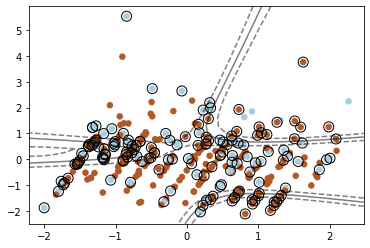

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = compute_pca(df, 2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

clf = SVC(**clf.best_params_)
clf.fit(X_train, Y_train)
clf.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)

# Plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])

# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

In [29]:
def compute_variance_proportion_for_pca(df):
    df = df.copy()    
    cov_matrix_list = []
    for y in df['Survival'].unique():
        df_class = df.loc[df['Survival'] == y]
        df_class = df_class.loc[:, df_class.columns != 'Survival']     
        df_class = (df_class - df_class.mean())/df_class.std()
        df_class = df_class - df_class.mean()
        cov_matrix_list.append(df_class.cov())
    eigen_values, eigen_vectors = np.linalg.eig(np.mean(cov_matrix_list, axis=0))
    for i in range(len(eigen_values)):
        print("K =", i + 1, f"gives {round(sum(eigen_values[: i + 1])/sum(eigen_values) * 100, 2)}% of possible variance")

compute_variance_proportion_for_pca(df)

K = 1 gives 36.46% of possible variance
K = 2 gives 66.75% of possible variance
K = 3 gives 100.0% of possible variance
